![課題_スクリーンショット](../img/課題.png)

## モデリングA

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import pickle

import seaborn as sns

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet

In [226]:
df = pd.read_csv('../data/apparel_clean.csv')
df.head()

,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,58507.0,0,0
1,1990-01-06,0.0,0.0,49088.0,0,0
2,1990-01-07,0.0,0.0,50066.0,0,0
3,1990-01-08,0.0,0.0,45954.0,0,0
4,1990-01-09,0.0,0.0,66422.0,0,0


In [227]:
df['ds'] = pd.to_datetime(df['ds'])
#df["y"] = np.log(df["y"]).replace([0, np.inf, -np.inf], np.nan)

train = df[df['ds'] <= '1992-12-31']
test = df[df['ds'] > '1992-12-31']

print('train shape:', train.shape)
print('test shape:', test.shape)

train_y = train['y']
test_y = test['y']
train_X = train.drop(columns=['y'])
test_X = test.drop(columns=['y'])

df.head(3)

train shape: (1092, 6)
test shape: (365, 6)


,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,58507.0,0,0
1,1990-01-06,0.0,0.0,49088.0,0,0
2,1990-01-07,0.0,0.0,50066.0,0,0


In [229]:
# 祝日かつ月曜日のデータについて、バーゲン実施有無ごとに集計
df_holiday_monday = df[(df['Holiday'] == 1) & (df['ds'].dt.dayofweek == 0)]

# バーゲン実施（Bargain=1）・非実施（Bargain=0）ごとの件数と平均売上
bargain_group = df_holiday_monday.groupby('Bargain')['y'].agg(['count', 'mean']).reset_index()

print("祝日かつ月曜日のバーゲン実施有無ごとの集計:")
print(bargain_group)

祝日かつ月曜日のバーゲン実施有無ごとの集計:
   Bargain  count          mean
0      0.0     15  80118.666667
1      1.0      2  96847.500000


In [230]:
# 祝日
h_holiday = df.loc[df['Holiday'] == 1, ['ds']].copy()
h_holiday['holiday'] = 'holiday'
h_holiday['lower_window'] = 0
h_holiday['upper_window'] = 0

# 天気
h_weather = df.loc[df['Weather'] == 1, ['ds']].copy()
h_weather['holiday'] = 'weather'
h_weather['lower_window'] = 0
h_weather['upper_window'] = 0

# バーゲン
h_bargain = df.loc[df['Bargain'] == 1, ['ds']].copy()
h_bargain['holiday'] = 'bargain'
h_bargain['lower_window'] = 0
h_bargain['upper_window'] = 0


# 休業日
h_closed = df.loc[df['Closed'] == 1, ['ds']].copy()
h_closed['holiday'] = 'closed'
h_closed['lower_window'] = 0
h_closed['upper_window'] = 0

holidays = pd.concat([h_holiday, h_weather, h_bargain, h_closed], ignore_index=True)
holidays = holidays[['holiday', 'ds', 'lower_window', 'upper_window']].sort_values(by='ds').reset_index(drop=True)
holidays.head(20)

,holiday,ds,lower_window,upper_window
0,bargain,1990-01-10,0,0
1,weather,1990-01-10,0,0
2,bargain,1990-01-11,0,0
3,bargain,1990-01-12,0,0
4,bargain,1990-01-13,0,0
5,weather,1990-01-13,0,0
6,holiday,1990-01-15,0,0
7,weather,1990-01-16,0,0
8,closed,1990-01-18,0,0
9,weather,1990-01-19,0,0


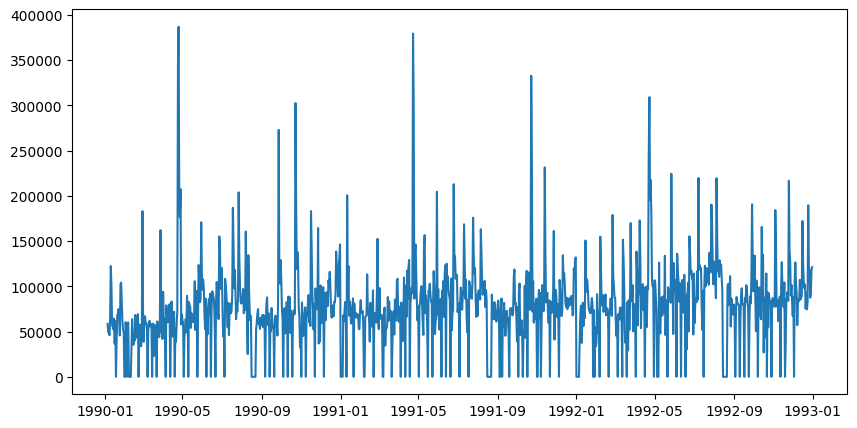

In [231]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(pd.to_datetime(train_X["ds"]), train_y)
plt.show()

In [232]:
train.head(20)

,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,58507.0,0,0
1,1990-01-06,0.0,0.0,49088.0,0,0
2,1990-01-07,0.0,0.0,50066.0,0,0
3,1990-01-08,0.0,0.0,45954.0,0,0
4,1990-01-09,0.0,0.0,66422.0,0,0
5,1990-01-10,1.0,1.0,122356.0,0,0
6,1990-01-11,0.0,1.0,100184.0,0,0
7,1990-01-12,0.0,1.0,57033.0,0,0
8,1990-01-13,1.0,1.0,55085.0,0,0
9,1990-01-14,0.0,0.0,52429.0,0,0


## 長期的なトレンド予測

17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing


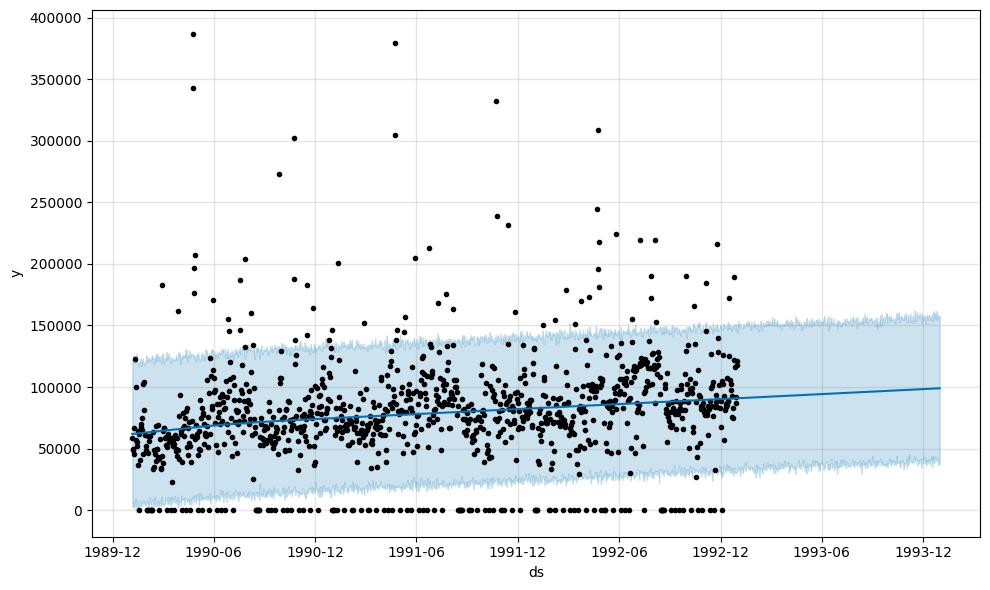

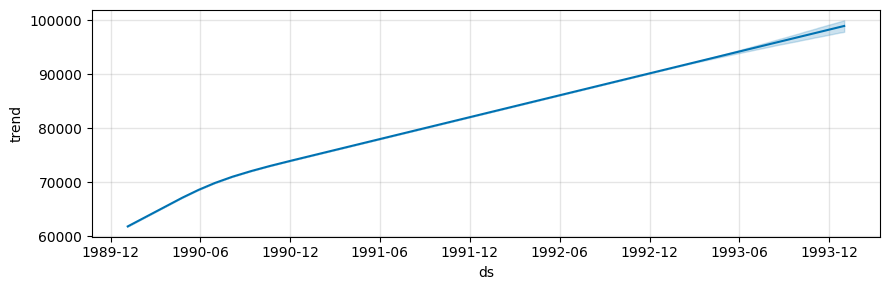

In [233]:
m = Prophet(weekly_seasonality = False, yearly_seasonality = False)
m.fit(train)

#予測する日付を生成
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [234]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'../models/model_a_1_{now}.pkl', 'wb') as f:
    pickle.dump(m, f)

17:03:33 - cmdstanpy - INFO - Chain [1] start processing
17:03:33 - cmdstanpy - INFO - Chain [1] done processing


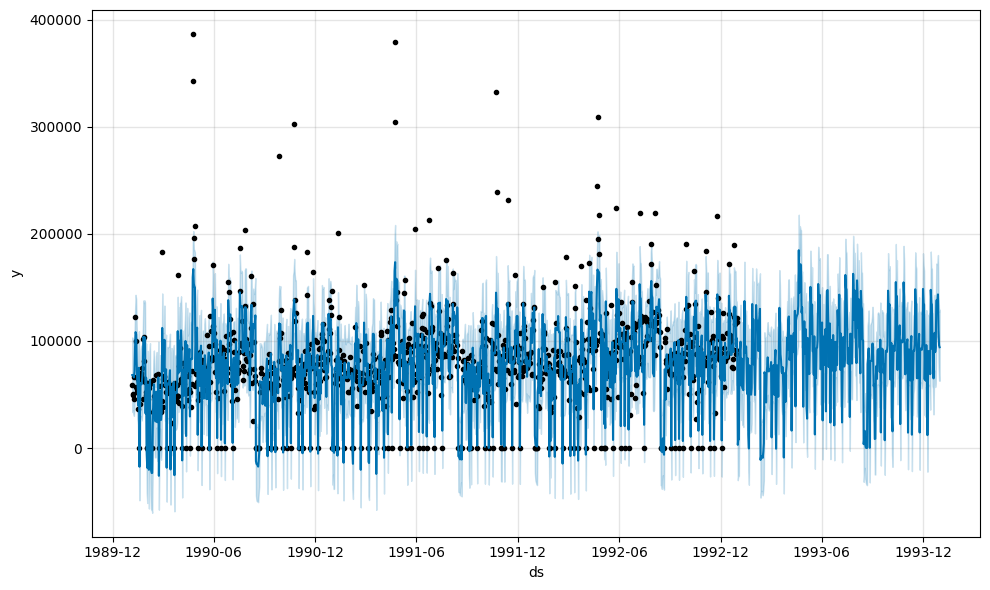

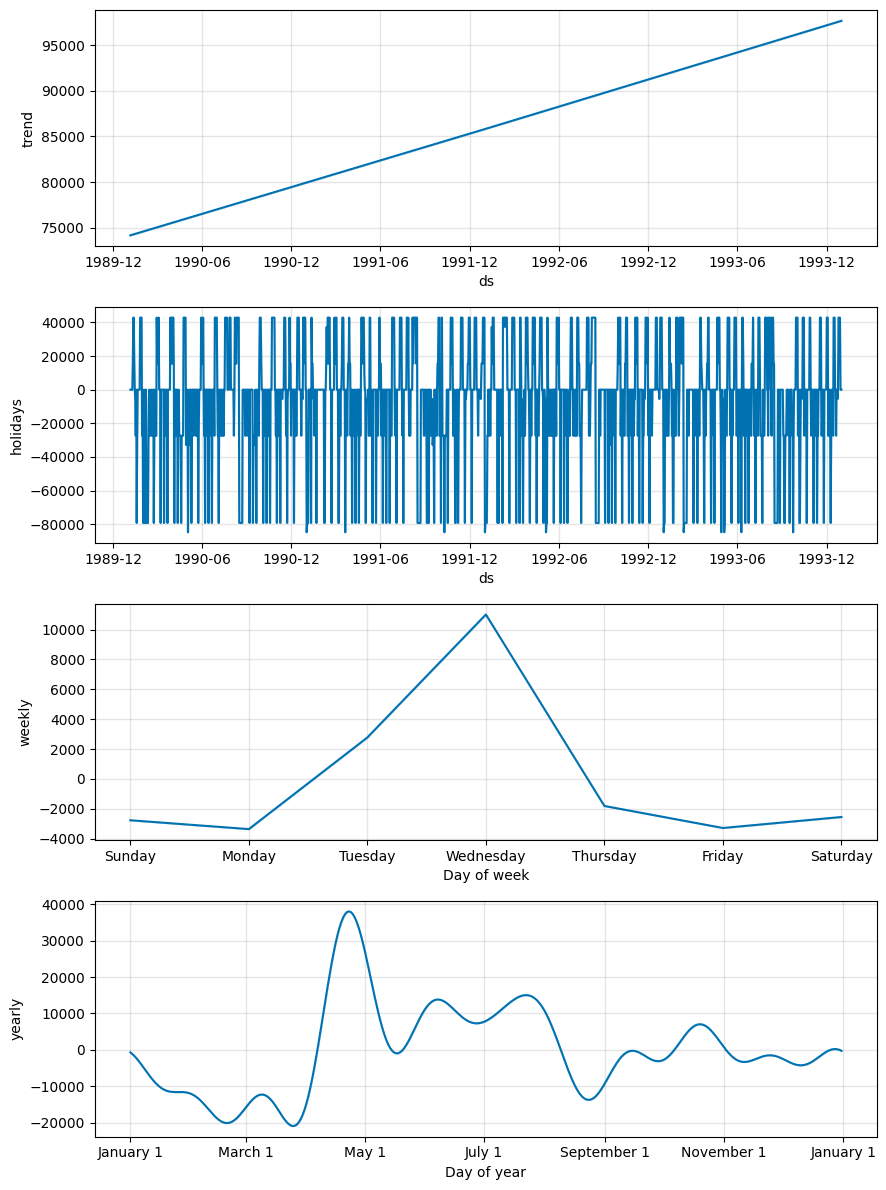

In [ ]:
m = Prophet(weekly_seasonality = True, yearly_seasonality = True, holidays= holidays)
m.fit(train)

#予測する日付を生成
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [236]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'../models/model_a_2_{now}.pkl', 'wb') as f:
    pickle.dump(m, f)

## テスト予測

,ds,yhat,yhat_lower,yhat_upper
0,1993-01-01,2971.490851,-31888.881193,37424.031657
1,1993-01-02,8818.970977,-25409.114318,43264.769098
2,1993-01-03,8099.751456,-24462.174674,44064.676314


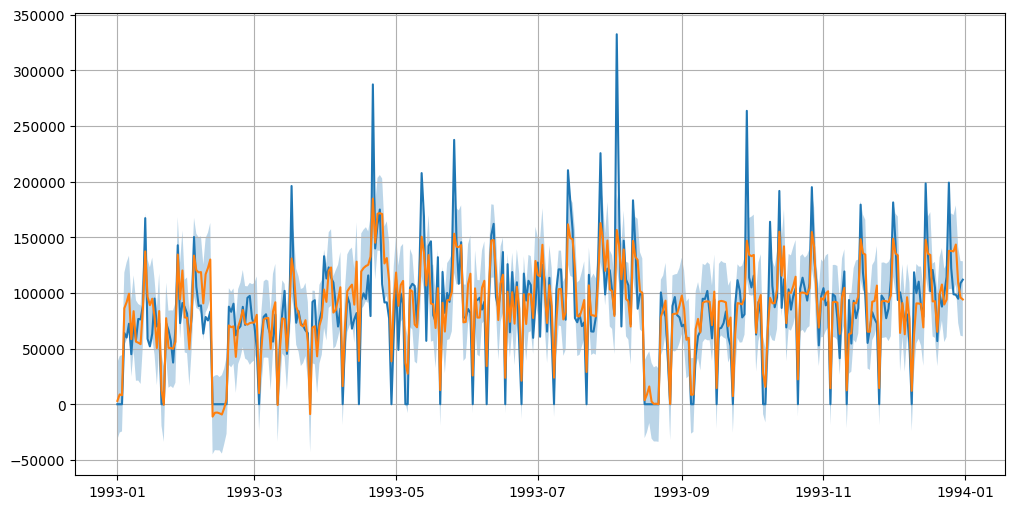

In [237]:
# テストデータの期間分だけ未来データを作成して予測する
test_periods = len(test)
future_test = m.make_future_dataframe(periods=test_periods, include_history=False)
forecast_test = m.predict(future_test)

display(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3))

plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.3, label='Uncertainty interval')
plt.grid()
plt.show()

In [238]:
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
print(f"MAE: {mae:.2f}")

MAE: 17879.19
